In [1]:
import pandas as pd
import glob
import math
import matplotlib.pyplot as plt
import plotly as ply
import plotly.express as px
import numpy as np
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pylab import rcParams
from helper_functions import load_data, get_data4uid


Using TensorFlow backend.
C:\Tools\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Tools\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Tools\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Tools\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be 

In [2]:
rcParams['figure.figsize'] = (15, 8)
# Load data
prices_pd, stations_pd = load_data('./Data/prices_40.sql')

### Forecast model

All libraries and data was loaded before, here i want to build a forecast model for fuel prices.
First I'll we have a closer look to the data with the statsmodel package. 


In [3]:
star_bahn = get_data4uid(prices_pd, '005056ba-7cb6-1ed2-bceb-82ea369c0d2d', 'diesel')

In [4]:
star_bahn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22543 entries, 2015-01-01 08:50:01+00:00 to 2019-12-20 22:03:03+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   diesel  22218 non-null  float64
dtypes: float64(1)
memory usage: 352.2 KB


In [5]:
# i want to use daily values for the ongoing analysis
# use ffill to have a value for each day, otherwise ARIMA model has problems

star_bahn.dropna(inplace=True)
star_day = star_bahn.resample('d').mean().ffill()


In [6]:
star_day = star_day.asfreq('d')
star_day.dropna(inplace=True)

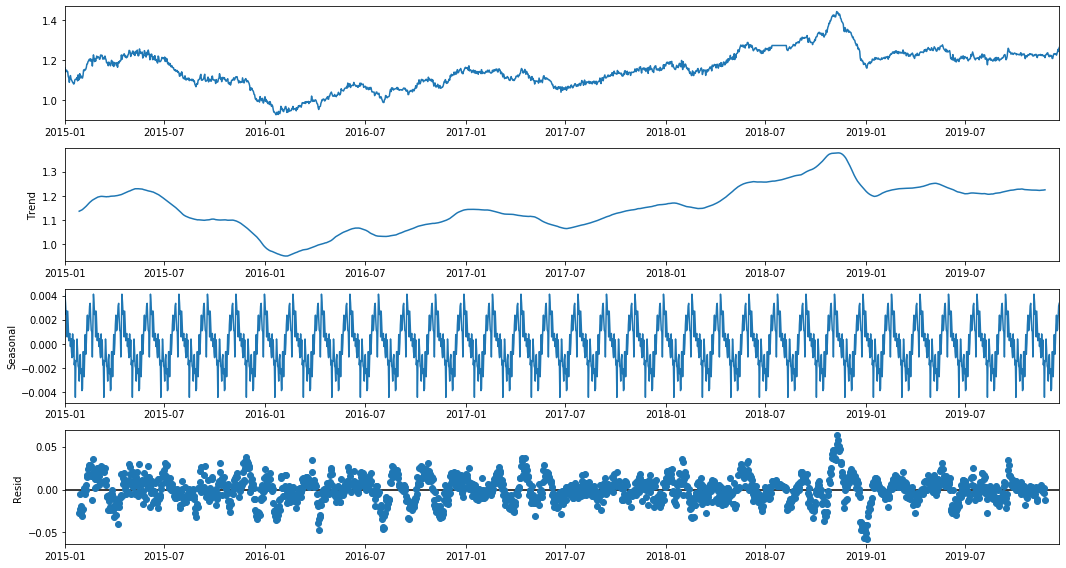

In [7]:
# let's see what is in the data, let assume a weekly seasonal
decompostion = sm.tsa.seasonal_decompose(star_day, period=52, model='additive')
decompostion.plot();

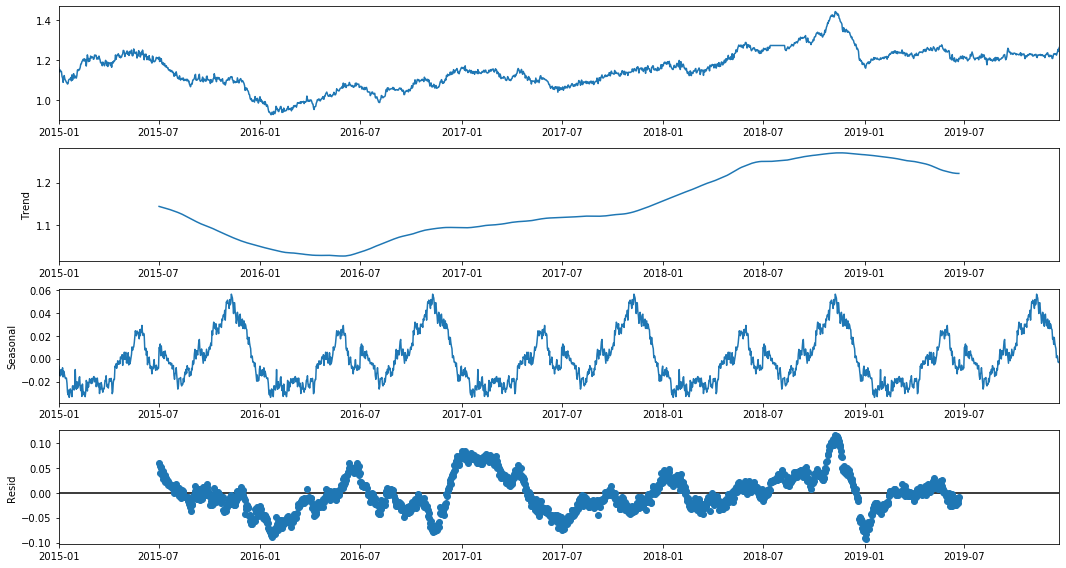

In [8]:
# now let's see if we a yearly seasonal aspect inside
decompostion = sm.tsa.seasonal_decompose(star_day, period=365, model='additive')
decompostion.plot();

### Trend and Saisonality

In the above plots you can easily see, there is a trend and a seasonal aspect in the data. In the first plot you'll see the weekly seasonal aspects and in the second plot you can also see a yearly seasonal aspect in the diesel price.
Therefore a standard ARIMA model will have problems with such data, even the SARIMA model, because the data is not stationary.

The stationarity can be forced with the difference, let's see...

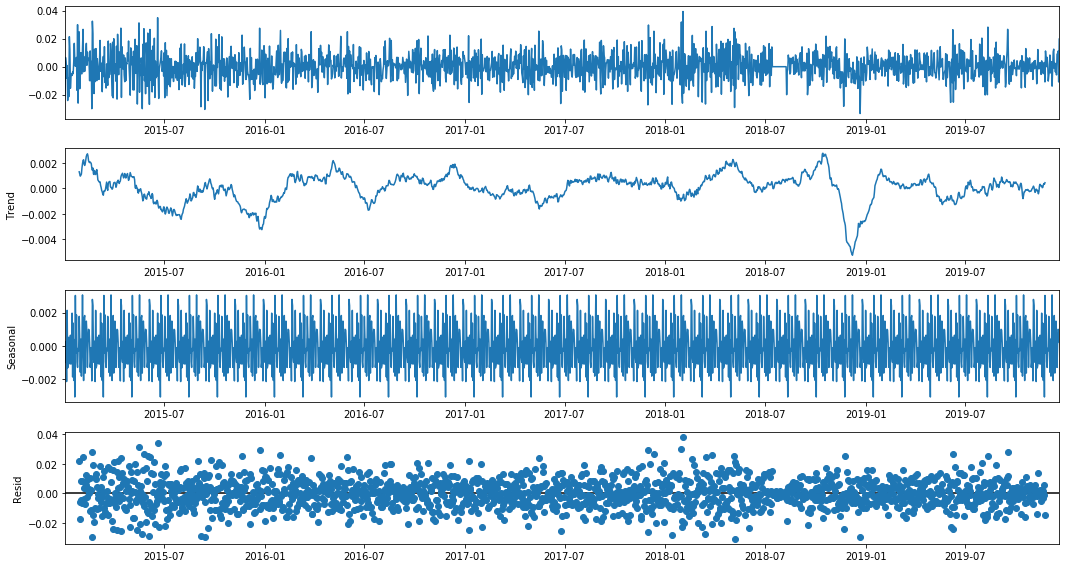

In [9]:
decompostion = sm.tsa.seasonal_decompose(star_day.diff().dropna(), period=52, model='additive')
decompostion.plot();

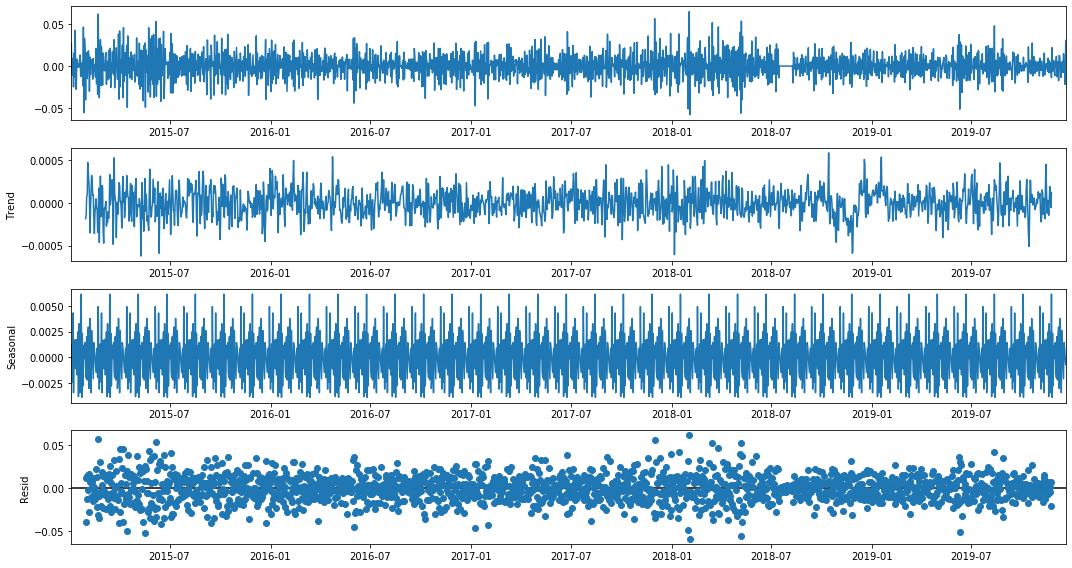

In [10]:
decompostion = sm.tsa.seasonal_decompose(star_day.diff().dropna().diff().dropna(), period=52, model='additive')
decompostion.plot();

Even in the first difference there is a small trend, it is removed when we diff a second time.

#### ACF/PACF
Let's see if it is also seen in ACF and PACF.

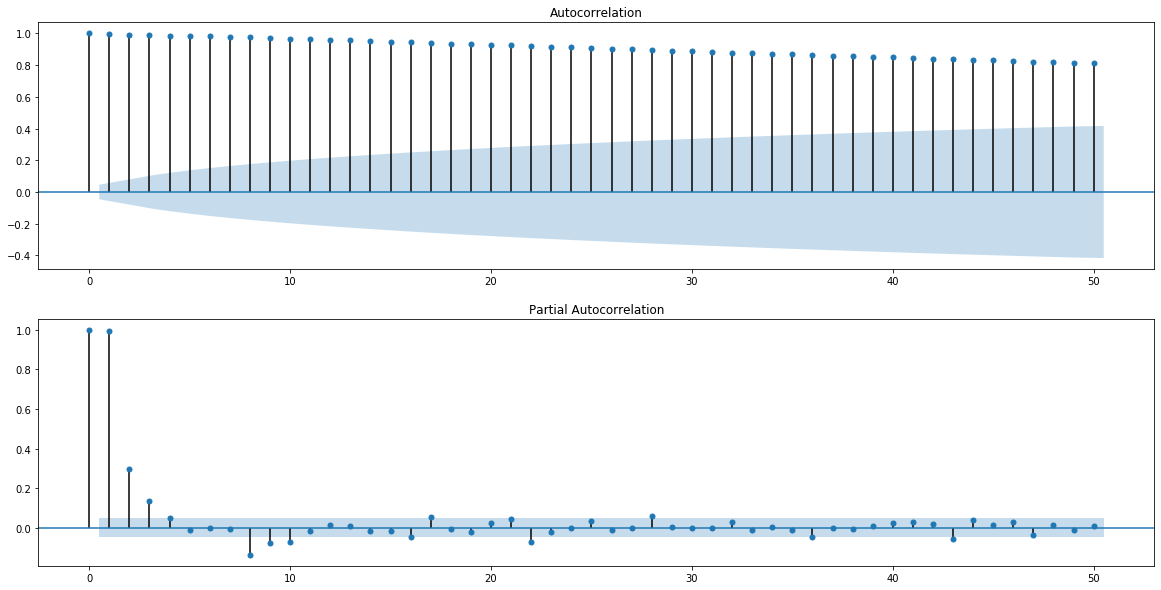

In [11]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(star_day.dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(star_day.dropna(), lags=50, ax=ax[1])
plt.show()

So from the ACF there is also clearly, that the raw data is not stationary. Let's see hte ACF and PACF for the first difference.

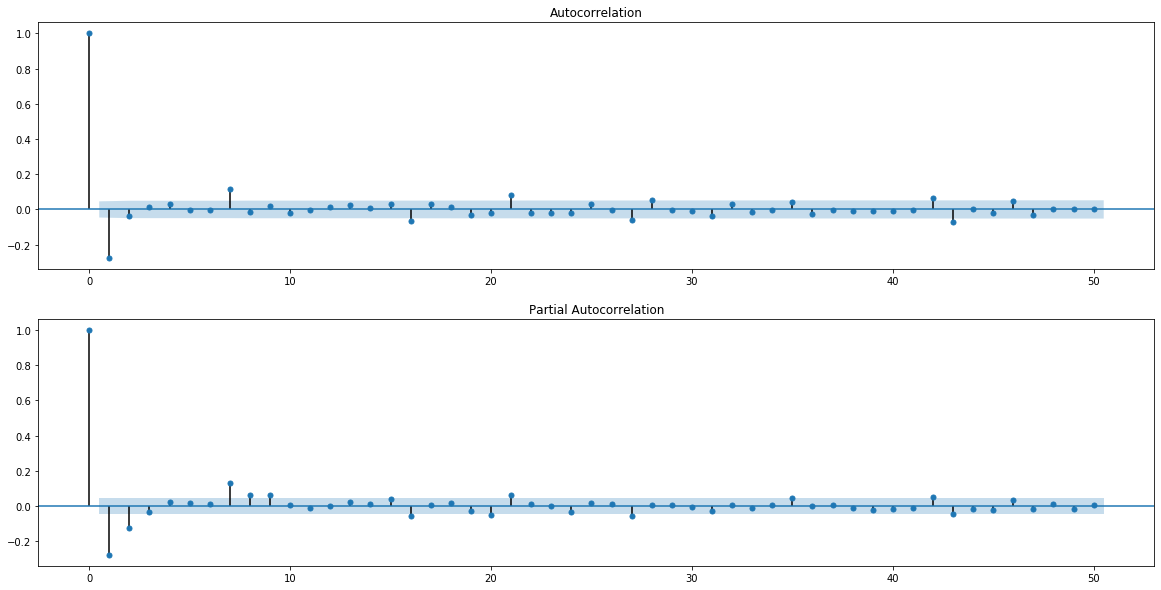

In [12]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(star_day.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(star_day.diff().dropna(), lags=50, ax=ax[1])
plt.show()

The original data is not stationary, seen in the Autocorrelation part. But the first difference seems to be good (means stationary). Let's see what the ADF and KPSS test will tell us about the raw data and the first difference.

In [13]:
# found this summary for all values of Adfuller and KPSS test usefull and therefore copy and pasted it here
def stationarity_test(ts):
    print('Results of ADF Test:')
    df = sm.tsa.adfuller(ts, autolag='AIC')
    df_out = pd.Series(df[0:3], index = ['Test Statistic', 'p-value', 'Number of lags'])
    for key,value in df[4].items():
        df_out['Critical Value (%s)'%key] = value
    print(df_out)
    
#When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).


In [14]:
stationarity_test(star_day.diesel.dropna())

Results of ADF Test:
Test Statistic         -1.759272
p-value                 0.400861
Number of lags          9.000000
Critical Value (1%)    -3.433978
Critical Value (5%)    -2.863143
Critical Value (10%)   -2.567623
dtype: float64


In [15]:
stationarity_test(star_day.diesel.diff().dropna())

Results of ADF Test:
Test Statistic         -1.181777e+01
p-value                 8.556667e-22
Number of lags          8.000000e+00
Critical Value (1%)    -3.433978e+00
Critical Value (5%)    -2.863143e+00
Critical Value (10%)   -2.567623e+00
dtype: float64


The Adfuller test for the first difference is also ok, the p-value is nearly zero, means the first difference is stationary. So we can use d=1 for the ARIMA model.
### ARIMA model

The ACF gives a hint for the q value (MA) and the PACF gives a hint for the p value (AR) for the ARIMA model. In the ACF/PACF plot from first difference you can see in ACF lag 1 and 7 outside the benchmark and for the PACF lag 1, 2, (3), 7, 8, 9 outside the benchmark. As a rule of thumb you should start with the least amount of lags outside the benchmark. So i'll start with q of 1.

In [16]:
star_day.index

DatetimeIndex(['2015-01-01 00:00:00+00:00', '2015-01-02 00:00:00+00:00',
               '2015-01-03 00:00:00+00:00', '2015-01-04 00:00:00+00:00',
               '2015-01-05 00:00:00+00:00', '2015-01-06 00:00:00+00:00',
               '2015-01-07 00:00:00+00:00', '2015-01-08 00:00:00+00:00',
               '2015-01-09 00:00:00+00:00', '2015-01-10 00:00:00+00:00',
               ...
               '2019-12-11 00:00:00+00:00', '2019-12-12 00:00:00+00:00',
               '2019-12-13 00:00:00+00:00', '2019-12-14 00:00:00+00:00',
               '2019-12-15 00:00:00+00:00', '2019-12-16 00:00:00+00:00',
               '2019-12-17 00:00:00+00:00', '2019-12-18 00:00:00+00:00',
               '2019-12-19 00:00:00+00:00', '2019-12-20 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=1815, freq='D')

In [17]:
star_day = star_day.tz_localize(None)

In [18]:
star_day.index = pd.DatetimeIndex(star_day.index).to_period('D')

In [19]:
star_day

,diesel
date,
2015-01-01,1.160667
2015-01-02,1.139909
2015-01-03,1.146500
2015-01-04,1.149000
2015-01-05,1.140667
...,...
2019-12-16,1.232478
2019-12-17,1.241727
2019-12-18,1.252889


In [20]:
# split train and test data
train = star_day['2015-01-01':'2018-12-31'].diesel
test = star_day['2019-01-01':].diesel
#train = train.tz_localize(None)
#test = test.tz_localize(None)

(1435, 354)

In [21]:
train.size, test.size

(1461, 354)

In [ ]:
model = sm.tsa.statespace.SARIMAX.

In [50]:
model_0 = sm.tsa.statespace.SARIMAX(endog=train, order=(0,1,1), seasonal_order=(0,1,1,52), enforce_invertibility=False)
results_0 = model_0.fit()

In [51]:
results_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             diesel   No. Observations:                 1461
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                4320.284
Date:                            Sun, 29 Mar 2020   AIC                          -8634.568
Time:                                    12:22:52   BIC                          -8618.936
Sample:                                01-01-2015   HQIC                         -8628.715
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3226      0.024    -13.489      0.000      -0.370      -0.276
ma.S.L52      -1.0015      0.889     -1.127      0.260      -2.744       0.741
sigma2      8.935e-05   8.03e-05      1.112      0.266   -6.81e-05       0.000
===================================================================================
Ljung-Box (Q):                       83.57   Jarque-Bera (JB):                22.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.09
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
#pred_0 = results_0.predict(start='2019-01-01', end='2019-12-20')
pred_0 = results_0.forecast(steps=354)
#pred_0.index = test.index
print('ARIMA model MSE:{}'.format(mean_squared_error(test,pred_0)))
print('R2 Score: {}'.format(r2_score(test,pred_0)))

ARIMA model MSE:0.0018276119076308455
R2 Score: -3.890660125625824


In [53]:
pred_0

2019-01-01    1.183021
2019-01-02    1.181305
2019-01-03    1.179944
2019-01-04    1.178317
2019-01-05    1.179247
                ...   
2019-12-16    1.191317
2019-12-17    1.191159
2019-12-18    1.191713
2019-12-19    1.193231
2019-12-20    1.194656
Freq: D, Length: 354, dtype: float64

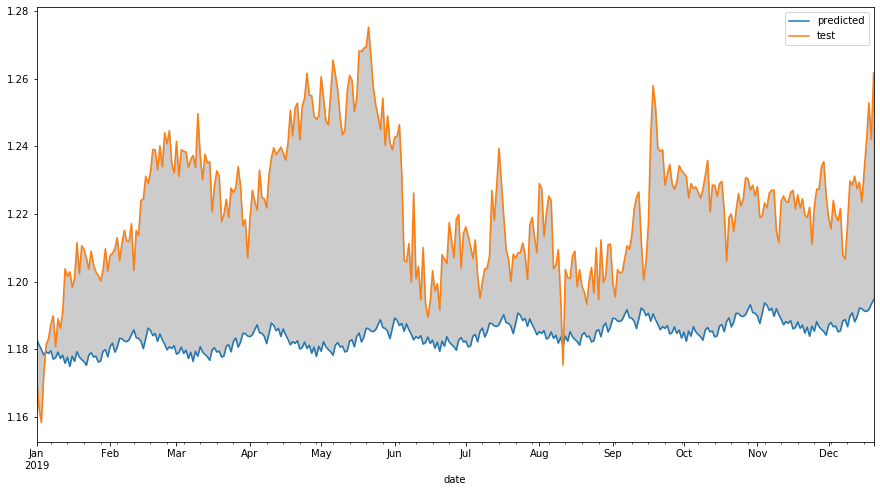

In [54]:
#pred_0.index = test.index
pred_0.plot(label='predicted')
test.plot(label='test')
plt.fill_between(pred_0.index,
                pred_0,
                test, color='k', alpha=.2)

plt.legend();

In [ ]:
#first try training with d=1 only
model_1 = sm.tsa.statespace.SARIMAX(endog=train, order=(0,1,1), seasonal_order=(3,0,2,52), enforce_invertibility=False)
results_1 = model_1.fit()

MemoryError: Unable to allocate 275. MiB for an array with shape (157, 157, 1462) and data type float64

In [ ]:
results_1.summary()

In [ ]:
pred_1 = results_1.forecast(steps=354) #(start='2019-01-01', end='2019-12-20')
print('ARIMA model MSE:{}'.format(mean_squared_error(test,pred_1)))
print('R2 Score: {}'.format(r2_score(test,pred_1)))

In [ ]:
#pred_1.index = test.index
pred_1.plot(label='predicted')
test.plot(label='test')
plt.fill_between(pred_1.index,
                pred_1,
                test, color='k', alpha=.2)

plt.legend();

In [35]:
#second try 
model_2 = sm.tsa.statespace.SARIMAX(endog=train, order=(3,1,2), seasonal_order=(0,1,2,52), enforce_invertibility=False)
results_2 = model_2.fit()

C:\Tools\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Tools\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [36]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             diesel   No. Observations:                 1461
Model:             SARIMAX(3, 1, 2)x(0, 1, 2, 52)   Log Likelihood                4448.375
Date:                            Sun, 29 Mar 2020   AIC                          -8880.751
Time:                                    17:12:53   BIC                          -8838.751
Sample:                                01-01-2015   HQIC                         -8865.055
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3975      0.390     -1.020      0.308      -1.161       0.366
ar.L2         -0.0241      0.287     -0.084      0.933      -0.587       0.539
ar.L3          0.0068      0.092      0.074      0.941      -0.174       0.187
ma.L1          2.2891      0.490      4.669      0.000       1.328       3.250
ma.L2         -0.8155      1.012     -0.806      0.421      -2.800       1.169
ma.S.L52      -0.9955      0.123     -8.093      0.000      -1.237      -0.754
ma.S.L104      0.0067      0.029      0.227      0.820      -0.051       0.064
sigma2      1.404e-05   1.99e-06      7.051      0.000    1.01e-05    1.79e-05
===================================================================================
Ljung-Box (Q):                       78.94   Jarque-Bera (JB):                25.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.68e+17. Standard errors may be unstable.
"""

In [37]:
pred_2 = results_2.forecast(steps=354)
print('ARIMA model MSE:{}'.format(mean_squared_error(test,pred_2)))
print('R2 Score: {}'.format(r2_score(test,pred_2)))

ARIMA model MSE:0.0017725142297072025
R2 Score: -3.74321962400147


In [38]:
pred_2

2019-01-01    1.183210
2019-01-02    1.181315
2019-01-03    1.180105
2019-01-04    1.178443
2019-01-05    1.179369
                ...   
2019-12-16    1.191087
2019-12-17    1.190918
2019-12-18    1.191465
2019-12-19    1.192980
2019-12-20    1.194423
Freq: D, Length: 354, dtype: float64

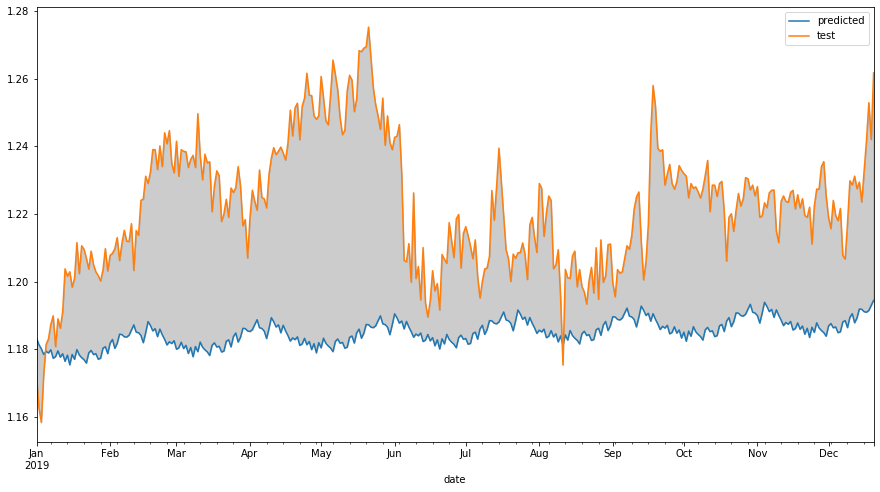

In [39]:
#pred_2.index = test.index
pred_2.plot(label='predicted')
test.plot(label='test')
plt.fill_between(pred_2.index,
                pred_2,
                test, color='k', alpha=.2)

plt.legend();

In [24]:
#3rd try
model_3 = sm.tsa.statespace.SARIMAX(endog=train, order=(3,1,3), seasonal_order=(3,1,3,52), enforce_invertibility=False)
results_3 = model_3.fit()

C:\Tools\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Tools\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [25]:
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             diesel   No. Observations:                 1461
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 52)   Log Likelihood                4452.506
Date:                            Sat, 28 Mar 2020   AIC                          -8879.011
Time:                                    12:16:02   BIC                          -8810.762
Sample:                                01-01-2015   HQIC                         -8853.505
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0794      0.479     -0.166      0.868      -1.019       0.860
ar.L2          0.4299      0.349      1.232      0.218      -0.254       1.114
ar.L3          0.0604      0.140      0.430      0.667      -0.215       0.336
ma.L1         -0.6087      3.368     -0.181      0.857      -7.209       5.992
ma.L2         -2.3202      2.356     -0.985      0.325      -6.938       2.297
ma.L3          0.8607      2.542      0.339      0.735      -4.121       5.843
ar.S.L52      -0.7262      0.775     -0.937      0.349      -2.246       0.793
ar.S.L104     -0.4362      0.624     -0.699      0.485      -1.659       0.787
ar.S.L156     -0.0432      0.044     -0.972      0.331      -0.130       0.044
ma.S.L52      -0.2543      0.777     -0.327      0.743      -1.777       1.268
ma.S.L104     -0.2957      0.945     -0.313      0.754      -2.149       1.557
ma.S.L156     -0.3685      0.620     -0.595      0.552      -1.583       0.846
sigma2      1.633e-05   4.48e-05      0.365      0.715   -7.14e-05       0.000
===================================================================================
Ljung-Box (Q):                       73.18   Jarque-Bera (JB):                25.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
pred_3 = results_3.forecast(steps=354)
print('ARIMA model MSE:{}'.format(mean_squared_error(test,pred_3)))
print('R2 Score: {}'.format(r2_score(test,pred_3)))

ARIMA model MSE:0.0014612303057145778
R2 Score: -2.9102288405300745


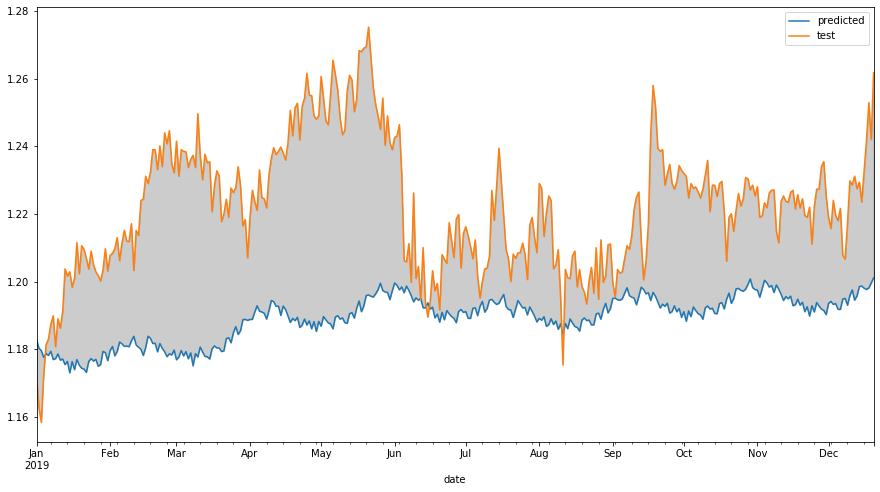

In [27]:
#pred_3.index = test.index
pred_3.plot(label='predicted')
test.plot(label='test')
plt.fill_between(pred_3.index,
                pred_3,
                test, color='k', alpha=.2)

plt.legend();

In [21]:
#4th try
model_4 = sm.tsa.statespace.SARIMAX(endog=train, order=(2,1,2), seasonal_order=(2,1,2,52), enforce_invertibility=False)
results_4 = model_4.fit()

MemoryError: Unable to allocate 3.06 GiB for an array with shape (530, 530, 1461) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels/tsa/statespace/_kalman_smoother.pyx", line 964, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
MemoryError: ((530, 530, 1461), dtype('float64'))


AttributeError: Memoryview is not initialized

In [ ]:
results_4.summary()

In [ ]:
pred_4 = results_4.forecast(steps=354)
print('ARIMA model MSE:{}'.format(mean_squared_error(test,pred_4)))
print('R2 Score: {}'.format(r2_score(test,pred_4)))

In [ ]:
pred_4.index = test.index
pred_4.plot(label='predicted')
test.plot(label='test')
plt.fill_between(pred_4.index,
                pred_4,
                test, color='k', alpha=.2)

plt.legend();

### Not Bad but also not good
The ARIMA model_2 has the best prediction for the test data set. Also it has big differences in some months.

### LSTM

I will now try to build a LSTM model for prediction. Therefore i will scale the input and divide in three sets: train, validation and test data.

In [21]:
# the values have to be normalized for LSTM
values = star_day['diesel'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [22]:
# use the same data for trainine up to 2018
train_size = len(star_day[:'2018-12-31'])
vali_size = 31 # let's take 1 month as validation set for fitting
test_size = len(scaled) - train_size - vali_size
train, vali, test = scaled[:train_size,:], scaled[train_size:train_size+vali_size,:], scaled[train_size+vali_size:, :]
print(len(train), len(vali), len(test))

1435 31 323


In [23]:
def create_data(dataset, look_back=1):
    '''creates two array of x and y out of the given array
    Input: Array of data, steps to look back
    Output: X, Y
    '''
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)



In [24]:
look_back = 2
trainX, trainY = create_data(train, look_back)
valiX, valiY = create_data(vali, look_back)
testX, testY = create_data(test, look_back)

1433
29
321


In [25]:
# reshape to make it usable as input for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valiX = np.reshape(valiX, (valiX.shape[0], 1, valiX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [26]:
# build a LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(valiX, valiY), verbose=0, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


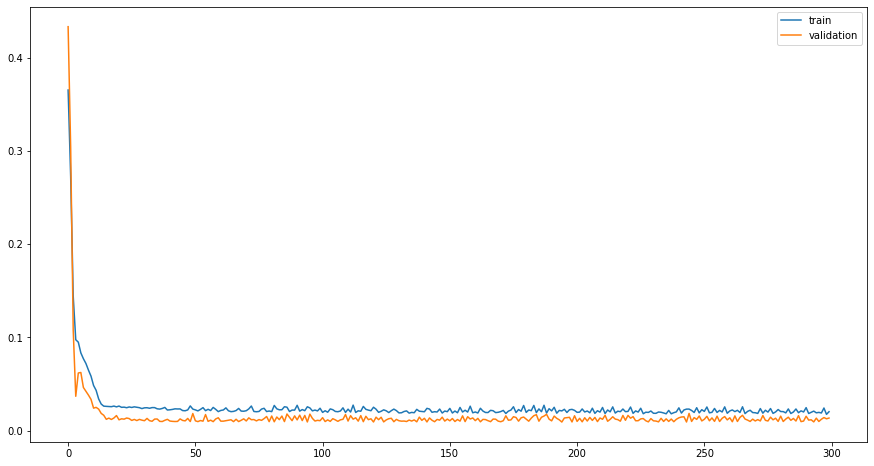

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [28]:
history.params

{'batch_size': 100,
 'epochs': 300,
 'steps': None,
 'samples': 1433,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'val_loss']}

In [29]:
# make predictions
train_pre = model.predict(trainX)
vali_pre = model.predict(valiX)
test_pre = model.predict(testX)
# invert predictions
train_pre = scaler.inverse_transform(train_pre)
trainY = scaler.inverse_transform([trainY])
vali_pre = scaler.inverse_transform(vali_pre)
valiY = scaler.inverse_transform([valiY])
test_pre = scaler.inverse_transform(test_pre)
testY = scaler.inverse_transform([testY])

# calculate mean squared error and R2 score
trainScore = mean_squared_error(trainY[0], train_pre[:,0])
print('Train Score MSE {}'.format(trainScore))
valiScore = mean_squared_error(valiY[0], vali_pre[:,0])
print('Validation Score MSE {}'.format(trainScore))
testScore = mean_squared_error(testY[0], test_pre[:,0])
print('Test Score MSE {}'.format(testScore))
print('Train R2 Score: {}'.format(r2_score(trainY[0],train_pre[:,0])))
print('Validation R2 Score: {}'.format(r2_score(valiY[0],vali_pre[:,0])))
print('Test R2 Score: {}'.format(r2_score(testY[0],test_pre[:,0])))


Train Score MSE 0.00015307747588089252
Validation Score MSE 0.00015307747588089252
Test Score MSE 0.00010629034344355478
Train R2 Score: 0.9832982156030171
Validation R2 Score: 0.5960002467415537
Test R2 Score: 0.658041508369376


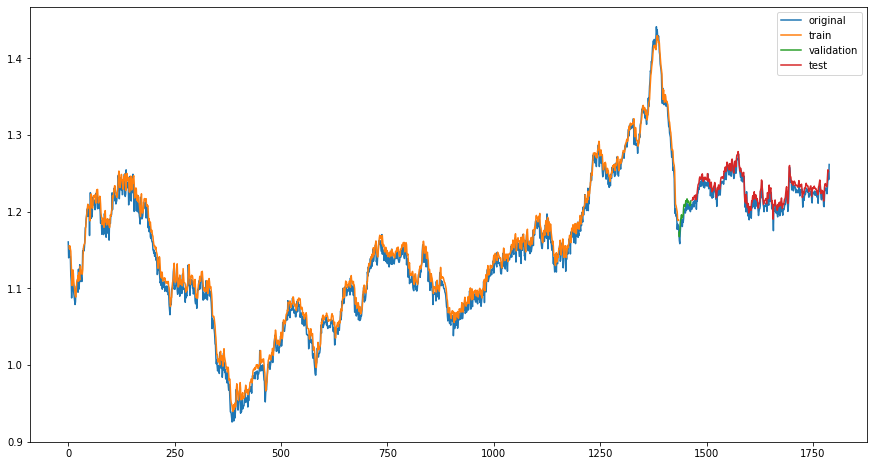

In [30]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_pre)+look_back, :] = train_pre
#shift test predictions for plotting
valiPredictPlot = np.empty_like(scaled)
valiPredictPlot[:, :] = np.nan
valiPredictPlot[len(train_pre)+(look_back*2)-2:len(train_pre)+vali_size, :] = vali_pre

# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_pre)+vali_size+(look_back*2)-2:len(scaled)-2, :] = test_pre
# plot baseline and predictions
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(valiPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['original', 'train', 'validation', 'test'])
plt.show()

In [31]:
# make a dataframe of the predictions and set index, the test data starts val_size + lookback in our case the 3rd february 2019
test_pre_pd = pd.DataFrame(test_pre)
test_pre_pd.index = star_day['2019-02-03':'2019-12-20'].index


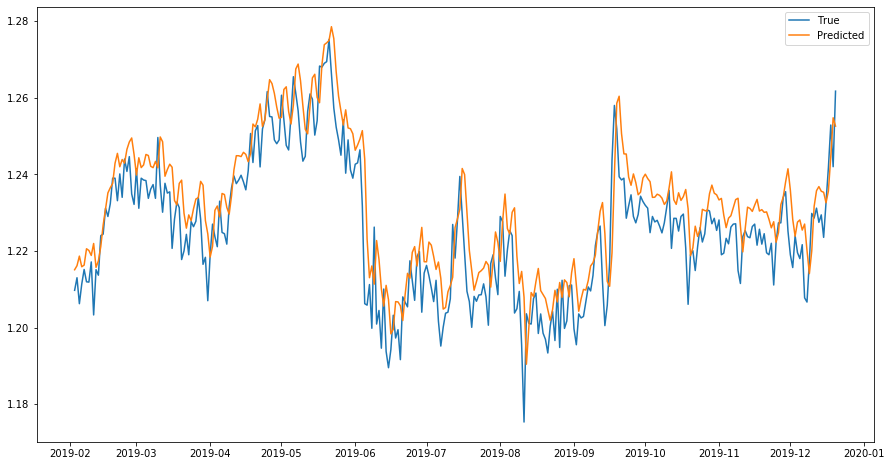

In [32]:
# let's have a closer look at the test data
plt.plot(star_day['2019-02-03':'2019-12-20'], label='True')
plt.plot(test_pre_pd, label='Predicted')
plt.legend();

### Good prediction?!?
In the first view the prediction of the test data on the right side in green seems to be very similar to the original data. We will have a closer look inside.

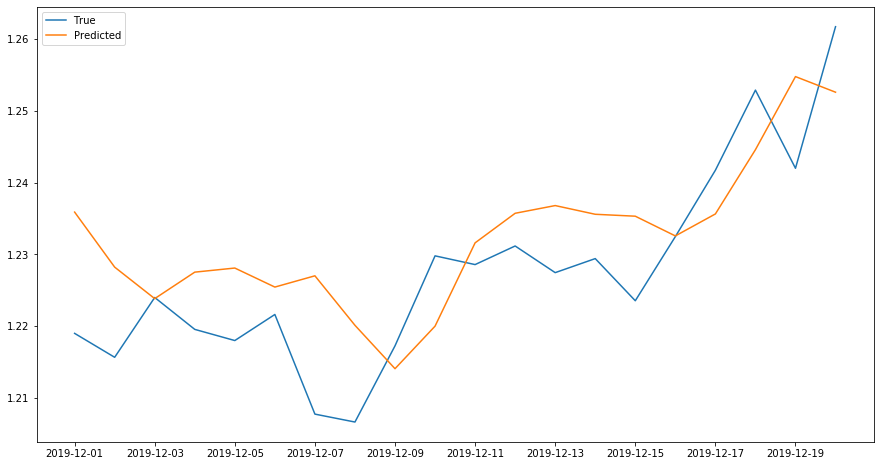

In [33]:
# let's have a closer look at the test data
plt.plot(star_day['2019-12-01':'2019-12-20'], label='True')
plt.plot(test_pre_pd['2019-12-01':'2019-12-20'], label='Predicted')
plt.legend();

The plots shows that the model fits very well even to the test data, but it is more a "follower" than a prediction.

### Predict the whole test data in sequence with own predictions


In [34]:
# code adapted from https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py
def predict_sequence_full(model, data, window_size):
    print('Predicting sequence...')
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        # predict one step
        predicted.append(model.predict(curr_frame[np.newaxis, :, :])[0,0])
        # add the prediction at the end
        curr_frame = np.insert(curr_frame[0], [window_size], predicted[-1], axis=0)
        # drop the first value, so we have new input for prediction with the last prediction
        curr_frame = curr_frame[np.newaxis, 1:]
    return predicted

# let's predict the test Sequence, but we'll only use the first data set
full_predict = predict_sequence_full(model, testX, 2)

Predicting sequence...


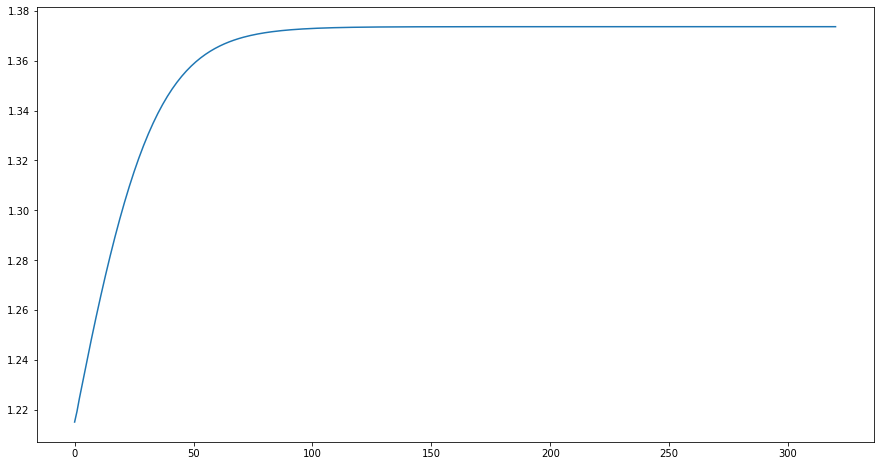

In [35]:
plt.plot(scaler.inverse_transform(np.array(full_predict).reshape(-1,1)));

Here we can see, that a prediction only based on the first test data set as input value is not possible for more days in the future with this model.


# Conclusion and lookout
You'll find the conclusion and lookout in the blog post included in github repository [Forecasting of Fuel prices in germany.pdf](./Forecasting%20of%20Fuel%20prices%20in%20germany.pdf)
